# Baseline

## Prepare data

In [7]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

TRAIN_PATH = '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train'
TEST_PATH = '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test'

to_tensor = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_data = ImageFolder(root=TRAIN_PATH, transform = to_tensor)
test_data = ImageFolder(root=TEST_PATH, transform = to_tensor)

## Example data 

Label :benign(0)
Label :benign(0)
Label :benign(0)
Label :malignant(1)
Label :malignant(1)
Label :malignant(1)


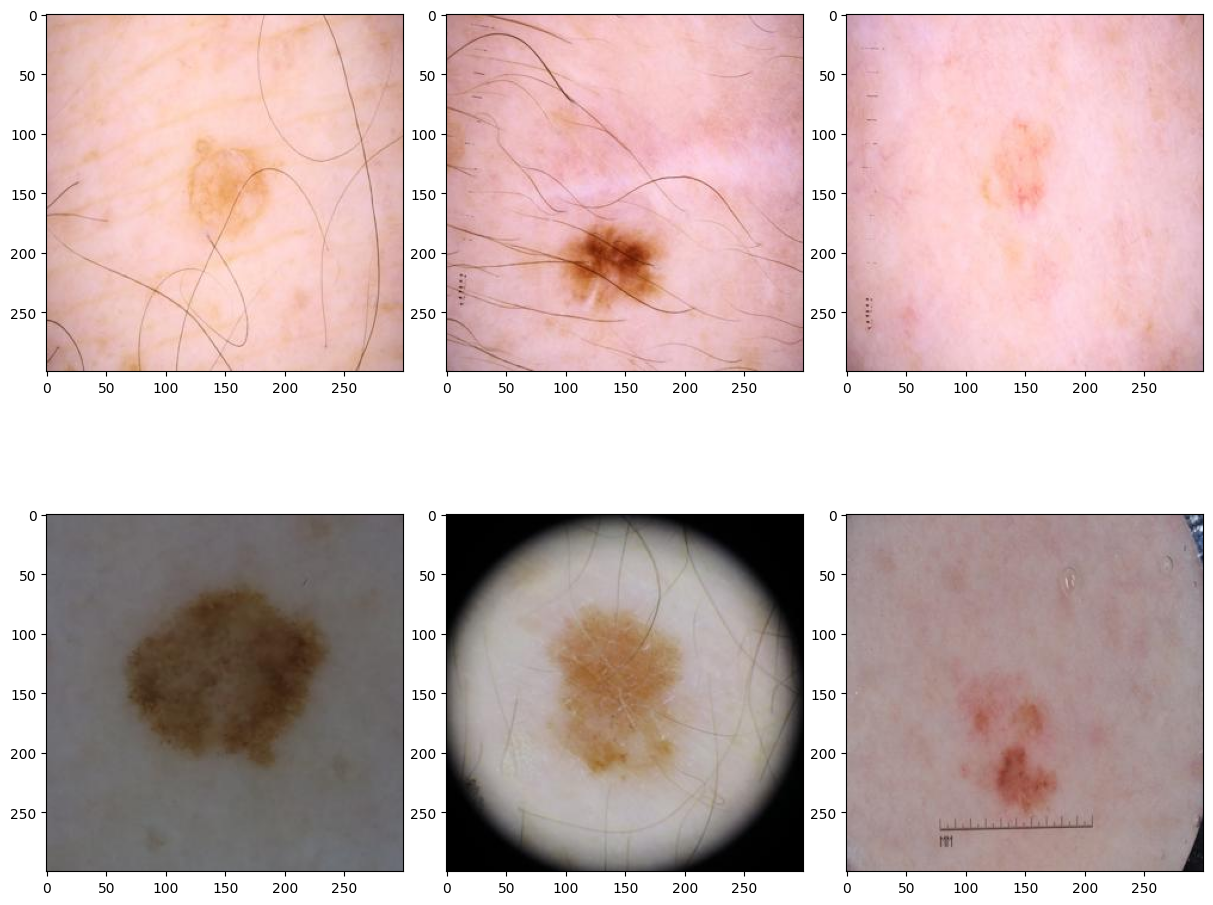

In [8]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

data = ImageFolder(TRAIN_PATH, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + data.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*data[1]))
axs[0,1].imshow(show_image(*data[2]))
axs[0, 2].imshow(show_image(*data[3]))
axs[1,0].imshow(show_image(*data[9000]))
axs[1,1].imshow(show_image(*data[9001]))
axs[1,2].imshow(show_image(*data[9002]))

## Helper function for calculating accuriacies

In [9]:
from torch import no_grad, max
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_accuracy(loader, model, device):
    model.eval()
    with no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def calculate_metrics(loader, model, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, precision, recall, f1, all_labels, all_predictions

## Training loop

In [10]:
import torch
import numpy as np
from torch.cuda import is_available
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from torch.amp.grad_scaler import GradScaler
from torch.amp import autocast
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import KFold

device = torch.device('cuda' if is_available() else 'cpu')

print(device.type)

def training_loop(architecture, training_data, num_of_epochs):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    models = []
    test_accuracies = []
    
    for train_index, val_index in kf.split(np.arange(len(train_data))):
        model = architecture()
        train_loader = DataLoader(Subset(training_data, train_index), batch_size=32, shuffle=True)
        val_loader = DataLoader(Subset(training_data, val_index), batch_size=32, shuffle=True)
        
        model = model.to(device)
        criterion = CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=0.001)
        scaler = GradScaler()

        train_losses = []
        val_accuracies = []

        for epoch in range(num_of_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                with autocast(device.type):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)
            val_accuracy = calculate_accuracy(val_loader, model, device)
            val_accuracies.append(val_accuracy)
            print(f'Epoch [{epoch+1}/{num_of_epochs}], Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
        test_accuracy, *_ = calculate_metrics(test_loader, model, device)
        test_accuracies.append(test_accuracy)
        models.append(model)
        print(f'Test Accuracy for current fold: {test_accuracy:.2f}%')

    best_model_idx = np.argmax(test_accuracies)
    best_model = models[best_model_idx]
    print(f'Best model test accuracy: {test_accuracies[best_model_idx]:.2f}%')
    return best_model

cuda


## Run training

In [11]:
from torchvision.models.alexnet import AlexNet
model = training_loop(AlexNet, train_data, 25)

Epoch [1/25], Loss: 0.8894, Validation Accuracy: 76.31%
Epoch [2/25], Loss: 0.4359, Validation Accuracy: 80.48%
Epoch [3/25], Loss: 0.4349, Validation Accuracy: 82.35%
Epoch [4/25], Loss: 0.3974, Validation Accuracy: 84.33%
Epoch [5/25], Loss: 0.3795, Validation Accuracy: 84.28%
Epoch [6/25], Loss: 0.3607, Validation Accuracy: 84.59%
Epoch [7/25], Loss: 0.3461, Validation Accuracy: 79.02%
Epoch [8/25], Loss: 0.3408, Validation Accuracy: 86.41%
Epoch [9/25], Loss: 0.3232, Validation Accuracy: 86.10%
Epoch [10/25], Loss: 0.3049, Validation Accuracy: 85.94%
Epoch [11/25], Loss: 0.2971, Validation Accuracy: 88.03%
Epoch [12/25], Loss: 0.2890, Validation Accuracy: 86.41%
Epoch [13/25], Loss: 0.2775, Validation Accuracy: 87.04%
Epoch [14/25], Loss: 0.2714, Validation Accuracy: 86.78%
Epoch [15/25], Loss: 0.2738, Validation Accuracy: 86.93%
Epoch [16/25], Loss: 0.2552, Validation Accuracy: 87.40%
Epoch [17/25], Loss: 0.2675, Validation Accuracy: 88.44%
Epoch [18/25], Loss: 0.2420, Validation 

## Augment data

In [12]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(90),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_train_data = ImageFolder(root=TRAIN_PATH, transform=train_transforms)


In [13]:
augmented_model = training_loop(AlexNet, augmented_train_data, 25)

Epoch [1/25], Loss: 0.6586, Validation Accuracy: 82.30%
Epoch [2/25], Loss: 0.4283, Validation Accuracy: 81.83%
Epoch [3/25], Loss: 0.3872, Validation Accuracy: 81.52%
Epoch [4/25], Loss: 0.3881, Validation Accuracy: 85.06%
Epoch [5/25], Loss: 0.3772, Validation Accuracy: 84.64%
Epoch [6/25], Loss: 0.3817, Validation Accuracy: 83.91%
Epoch [7/25], Loss: 0.3700, Validation Accuracy: 85.22%
Epoch [8/25], Loss: 0.5946, Validation Accuracy: 84.49%
Epoch [9/25], Loss: 0.4017, Validation Accuracy: 85.42%
Epoch [10/25], Loss: 0.3631, Validation Accuracy: 85.16%
Epoch [11/25], Loss: 0.3710, Validation Accuracy: 83.03%
Epoch [12/25], Loss: 0.3923, Validation Accuracy: 86.05%
Epoch [13/25], Loss: 0.3748, Validation Accuracy: 84.54%
Epoch [14/25], Loss: 0.3578, Validation Accuracy: 85.53%
Epoch [15/25], Loss: 0.3617, Validation Accuracy: 87.04%
Epoch [16/25], Loss: 0.3521, Validation Accuracy: 82.98%
Epoch [17/25], Loss: 0.3740, Validation Accuracy: 83.45%
Epoch [18/25], Loss: 0.5020, Validation 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy for current fold: 50.00%
Epoch [1/25], Loss: 0.6854, Validation Accuracy: 81.99%
Epoch [2/25], Loss: 0.4192, Validation Accuracy: 82.77%
Epoch [3/25], Loss: 0.4064, Validation Accuracy: 82.30%
Epoch [4/25], Loss: 0.3839, Validation Accuracy: 85.06%
Epoch [5/25], Loss: 0.3904, Validation Accuracy: 84.96%
Epoch [6/25], Loss: 0.3787, Validation Accuracy: 83.50%
Epoch [7/25], Loss: 0.3624, Validation Accuracy: 85.63%
Epoch [8/25], Loss: 0.3715, Validation Accuracy: 85.48%
Epoch [9/25], Loss: 0.3716, Validation Accuracy: 85.79%
Epoch [10/25], Loss: 0.3466, Validation Accuracy: 79.33%
Epoch [11/25], Loss: 0.3984, Validation Accuracy: 86.26%
Epoch [12/25], Loss: 0.3583, Validation Accuracy: 85.68%
Epoch [13/25], Loss: 0.3825, Validation Accuracy: 81.47%
Epoch [14/25], Loss: 0.3688, Validation Accuracy: 85.16%
Epoch [15/25], Loss: 0.3750, Validation Accuracy: 81.73%
Epoch [16/25], Loss: 0.3568, Validation Accuracy: 84.70%
Epoch [17/25], Loss: 0.4503, Validation Accuracy: 72.88%
E

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save model

In [14]:
torch.save(model, "model.pt")
torch.save(augmented_model, "augmented_model.pt")